<a href="https://colab.research.google.com/github/tjdux/ML/blob/main/19_image_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 패션 MNIST 데이터 불러오기
- 데이터 일렬로 펼칠 필요 없음
- 입력 이미지는 항상 깊이(채널) 차원이 있어야 함

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0 #(48000, 28, 28, 1)
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 합성곱 신경망 만들기

In [2]:
# 첫 번째 합성곱 층: 32개의 필터, (3, 3) 커널, 렐루 활성화 함수, 세임 패딩, 입력 차원 지정
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation="relu", padding="same", input_shape=(28, 28, 1)))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
# 풀링 층: (2, 2) 풀링: (28, 28, 32) => (14, 14, 32)
model.add(keras.layers.MaxPooling2D(2))

In [4]:
# 두 번째 합성곱-풀링 층: (7, 7, 64)
model.add(keras.layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")) # 깊이가 32인 필터
model.add(keras.layers.MaxPooling2D(2))

In [5]:
# 일렬로 펼친 후 밀집 은닉층 + 출력층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation="softmax"))

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

- 특성 맵의 깊이는 늘어나고, 가로세로 크기는 줄어듦
- 첫 번째 합성곱 층의 파라미터 개수: 3 * 3 * 1 * 32 + 32 = 320
- 두 번째 합성곱 층의 파라미터 개수: 3 * 3 * 32 * 64 + 64 = 18496
- 은닉층의 파라미터 개수: 3136 * 100 + 100 = 313700
- 출력층의 파라미터 개수: 100 * 10 + 10 = 1010

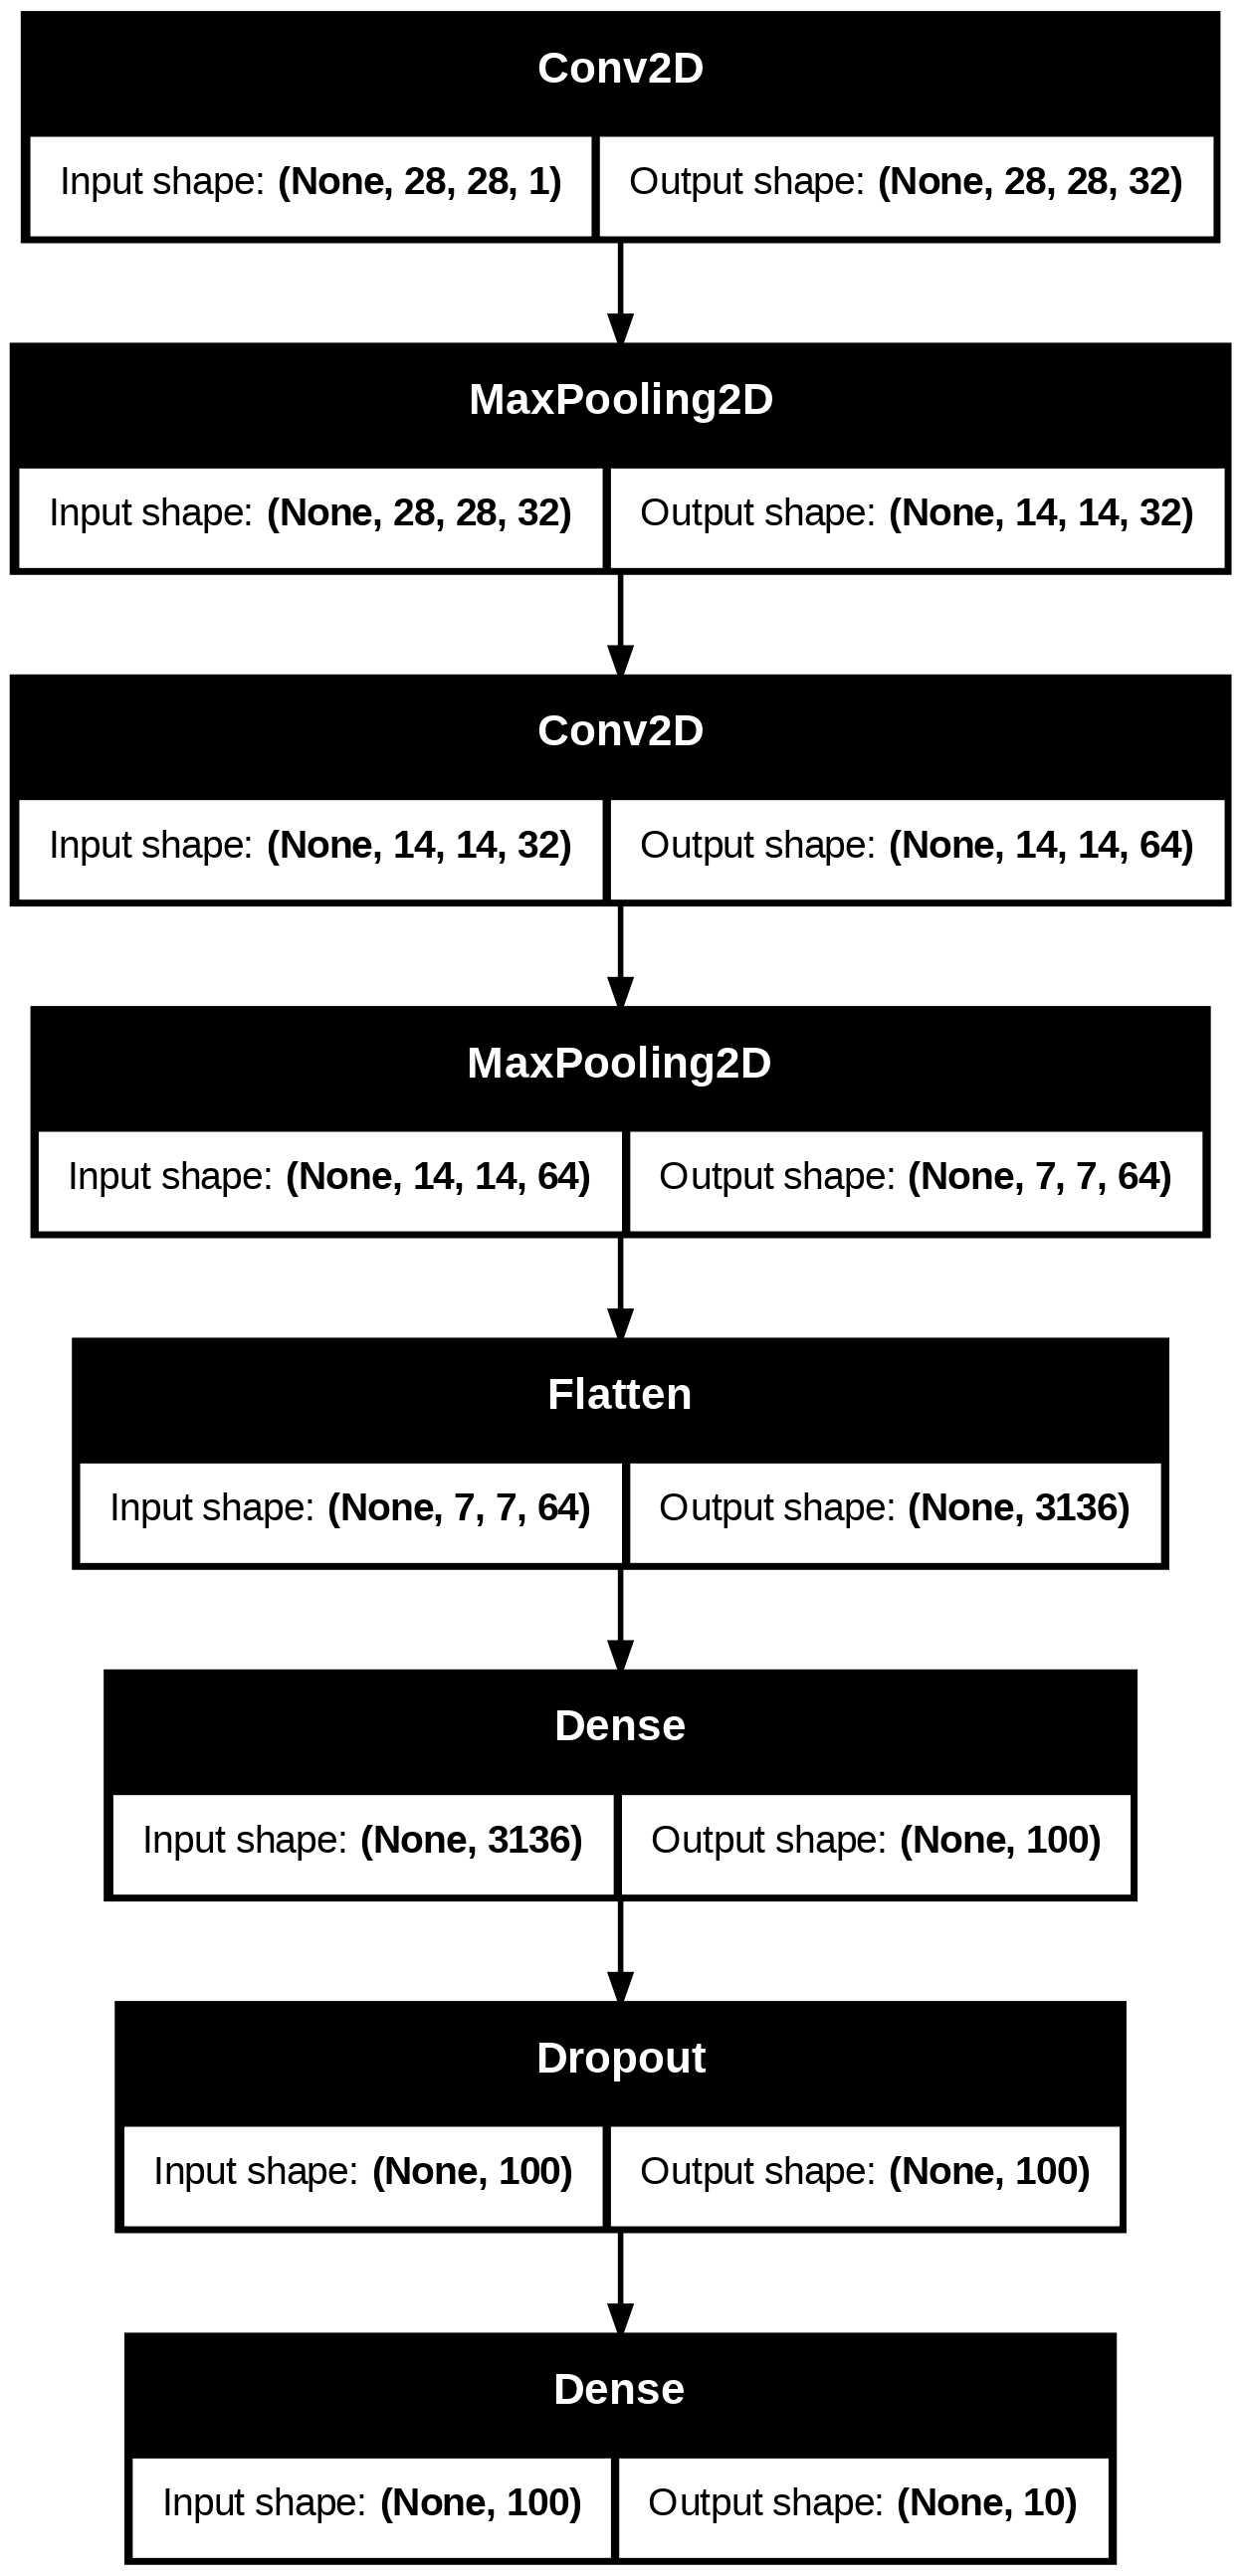

In [7]:
keras.utils.plot_model(model, show_shapes=True)

![img](https://velog.velcdn.com/images/dltpdl31/post/fddd236c-6860-4f68-863f-bb07f99d8002/image.png)

## 모델 컴파일과 훈련

In [8]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-cnn-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True) # retore_best_weights: 최적의 매개변수 저장
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7413 - loss: 0.7162

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7415 - loss: 0.7156 - val_accuracy: 0.8762 - val_loss: 0.3361
Epoch 2/20
1488/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.3647

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8686 - loss: 0.3646 - val_accuracy: 0.8975 - val_loss: 0.2837
Epoch 3/20
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8904 - loss: 0.3045

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8904 - loss: 0.3044 - val_accuracy: 0.8971 - val_loss: 0.2810
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9004 - loss: 0.2714 - val_accuracy: 0.8929 - val_loss: 0.2821
Epoch 5/20
1484/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9132 - loss: 0.2402

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9132 - loss: 0.2402 - val_accuracy: 0.9133 - val_loss: 0.2300
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9167 - loss: 0.2234 - val_accuracy: 0.9110 - val_loss: 0.2376
Epoch 7/20
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9244 - loss: 0.2041

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9244 - loss: 0.2041 - val_accuracy: 0.9203 - val_loss: 0.2217
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9290 - loss: 0.1918 - val_accuracy: 0.9180 - val_loss: 0.2254
Epoch 9/20
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9354 - loss: 0.1736

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9354 - loss: 0.1736 - val_accuracy: 0.9208 - val_loss: 0.2212
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9395 - loss: 0.1581 - val_accuracy: 0.9178 - val_loss: 0.2418
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9431 - loss: 0.1474 - val_accuracy: 0.9222 - val_loss: 0.2270


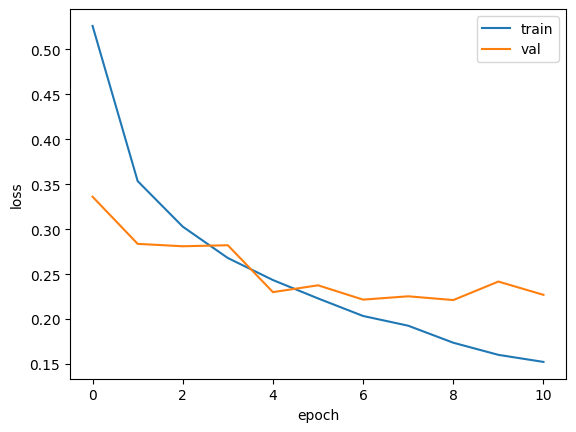

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

- 👉 아홉 번째 에포크가 최적의 에포크

In [10]:
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9234 - loss: 0.2135


[0.22119802236557007, 0.9207500219345093]

### 새로운 데이터에 대한 예측

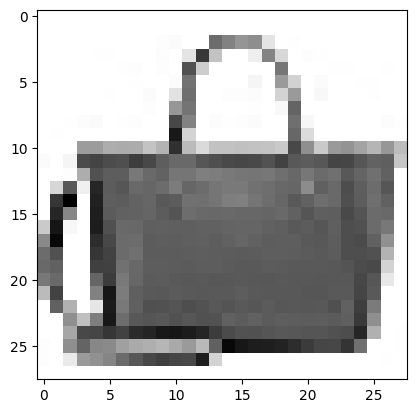

In [11]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap="gray_r")
plt.show()

In [12]:
preds = model.predict(val_scaled[0:1])
print(preds) # 9번째 클래스의 확률이 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
[[1.7729419e-21 2.2861576e-25 2.5153064e-21 2.0270564e-23 8.5297024e-23
  4.9334528e-22 6.5998324e-20 3.0638027e-20 1.0000000e+00 1.9930964e-23]]


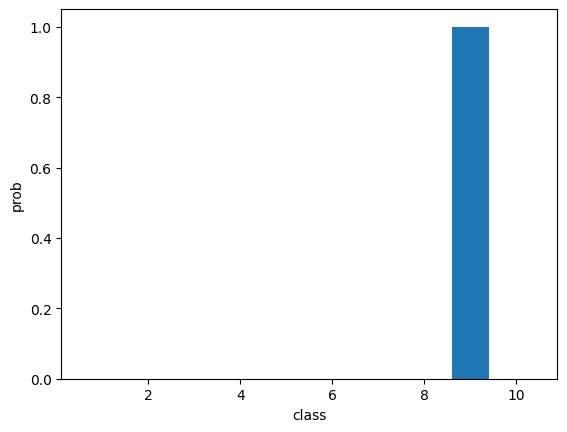

In [13]:
plt.bar(range(1, 11), preds[0])
plt.xlabel("class")
plt.ylabel("prob")
plt.show()

In [14]:
import numpy as np

classes = ["티셔츠", "바지", "스웨터", "드레스", "코트", "샌달", "셔츠", "스니커즈", "가방", "앵클 부츠"]

print(classes[np.argmax(preds)])

가방


In [15]:
# 테스트 세트에 대한 성능

test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9184 - loss: 0.2417


[0.24222837388515472, 0.917900025844574]